In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

In [3]:
ANGLES = [0, 90, 180, 270]
DISTANCE = 2
RESIZE_VALUE = (224, 224)
L = 8

In [4]:
DATA_DIR = "data"

In [5]:
def report(source, contr, source_co, ) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(first, cmap='gray')
    axes[1].imshow(second, cmap='gray')
    plt.show()

In [6]:
def get_glcm(image, distance=DISTANCE, angles=ANGLES, normalize=True):
    rows, cols = image.shape
    
    result = np.zeros((256, 256), dtype=np.uint32)
    
    for angle in angles:
        offset_row = round(math.sin(angle / 180 * math.pi) * distance)
        offset_col = round(math.cos(angle / 180 * math.pi) * distance)
        start_row = max(0, -offset_row)
        end_row = min(rows, rows - offset_row)
        start_col = max(0, -offset_col)
        end_col = min(cols, cols - offset_col)
        for r in range(start_row, end_row):
            for c in range(start_col, end_col):
                i = image[r, c]
                row = r + offset_row
                col = c + offset_col
                j = image[row, col]
                result[i, j] += 1
                
    if normalize:
        result = result / result.sum()
        
    return result


def calc_features(glcm):    
    indices = np.arange(len(glcm))
    sub = np.subtract.outer(indices, indices)**2
    
    con = (sub * glcm).sum()
    lun = (glcm / (sub + 1)).sum()
    
    return con, lun


def contrast(image, degree=L):
    scale = 2**(degree - 1)
    mean = int(image.mean())
    
    pos_range = max(2, image.max() - mean)
    neg_range = max(2, mean - image.min())
    
    pos_alpha = scale / math.log(pos_range)
    neg_alpha = scale / math.log(neg_range)
            
    sub = np.int32(image) - mean
    pos_mask = sub >= 1
    neg_mask = sub <= -1
        
    result = np.int32(np.full_like(image, mean))
    result[pos_mask] = mean + np.ceil(pos_alpha * np.log(sub[pos_mask]))
    result[neg_mask] = mean - np.ceil(neg_alpha * np.log(np.abs(sub[neg_mask])))
    
    result = (result - result.min()) / (result.max() - result.min())
    result = np.uint8(result * 255)
    
    return result

wildgrass.png


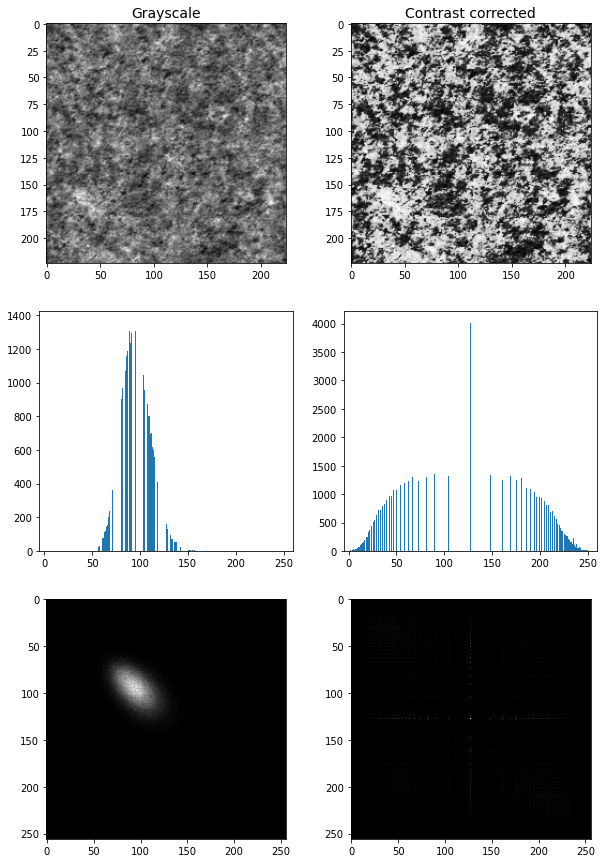

Features
CON: 226.6, LUN: 0.082
CON: 8370.6, LUN: 0.064


gravel.png


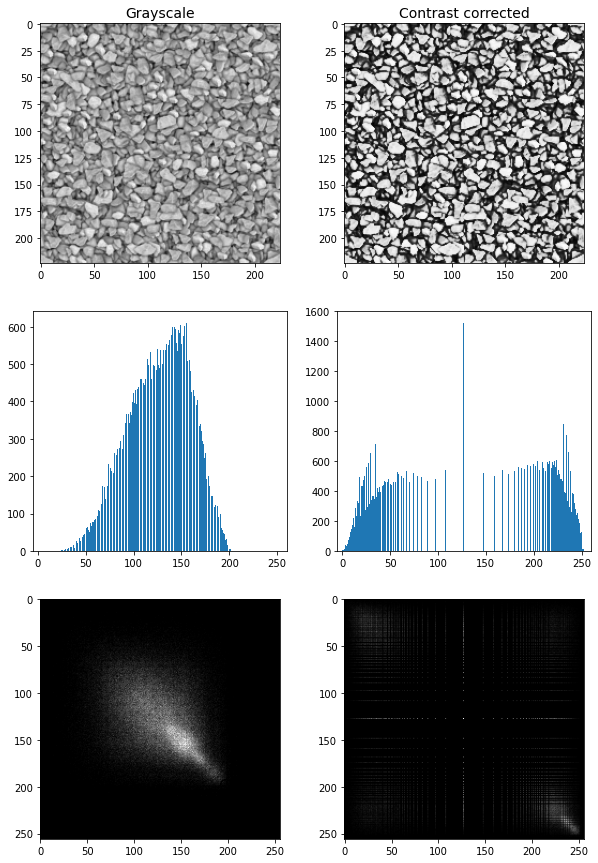

Features
CON: 1265.0, LUN: 0.047
CON: 13707.9, LUN: 0.067


water.bmp


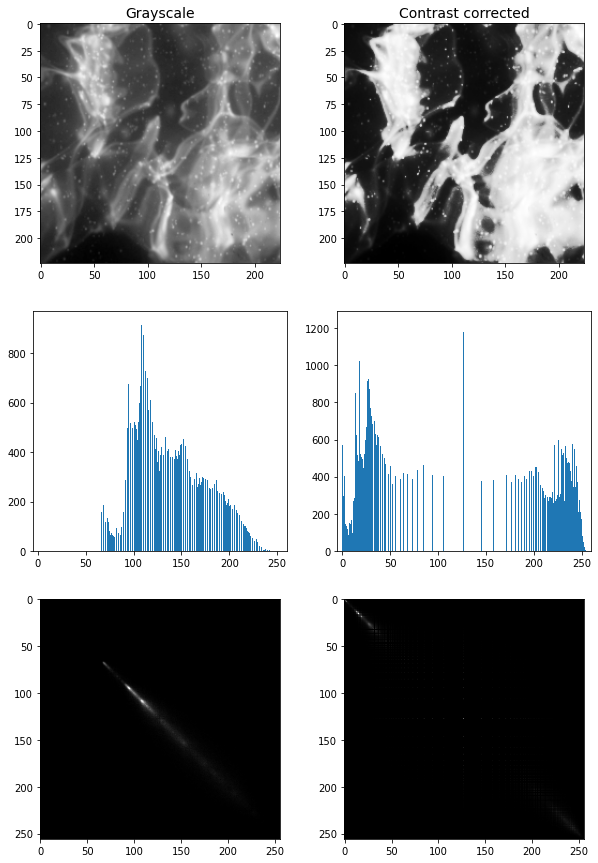

Features
CON: 97.6, LUN: 0.225
CON: 1172.3, LUN: 0.349




In [7]:
for fname in os.listdir(DATA_DIR):
    print(fname)
    image = Image.open(os.path.join(DATA_DIR, fname))
    image = image.resize(RESIZE_VALUE, resample=Image.BILINEAR)
    src = np.uint8(np.array(image).mean(2))
    contr = contrast(src, degree=L)
    
    src_glcm = get_glcm(src)
    src_features = calc_features(src_glcm)
    
    contr_glcm = np.log2(get_glcm(contr) + 1)
    contr_features = calc_features(contr_glcm)
        
    _, axes = plt.subplots(3, 2, figsize=(10, 15))
    axes[0, 0].imshow(src, cmap='gray')
    axes[0, 0].set_title("Grayscale", size=14)
    
    axes[0, 1].imshow(contr, cmap='gray')
    axes[0, 1].set_title("Contrast corrected", size=14)
    
    axes[1, 0].hist(src.ravel(), bins=256)
    axes[1, 0].set_xlim(-5, 260)
    axes[1, 1].hist(contr.ravel(), bins=256)
    axes[1, 1].set_xlim(-5, 260)
    
    axes[2, 0].imshow(src_glcm, cmap='gray')    
    axes[2, 1].imshow(contr_glcm, cmap='gray')
    
    plt.show()
    
    print("Features")
    print(f"CON: {round(src_features[0], 1)}, LUN: {round(src_features[1], 3)}")
    print(f"CON: {round(contr_features[0], 1)}, LUN: {round(contr_features[1], 3)}")
    
    print("\n")